In [1]:
using JLD2, FileIO
using Quaternions
using LinearAlgebra
using Statistics
using PyPlot
using MLDatasets
using ImageCore
using Images
using Random
using Printf
include("QRPNN.jl")
rng = MersenneTwister(1234);

In [2]:
# load full training set
train_x, train_y = CIFAR10.traindata();

In [3]:
# Parameters;
L = 5.0;
alpha = 40.0;
q = 70.0;
it_max = 1.e3

params=[nothing,alpha,L,q]
fs = [QRPNN.identity, QRPNN.exponential, QRPNN.potential, QRPNN.high_order];
fsNames = ["Identity","Exponential","Potential","High_Order"];

In [4]:
P = 200;
N = 32*32;
tau = 1.e-4;
NoiseValue = 0.1;

In [5]:
# Generate the fundamental memories
indFM = randperm(rng, size(train_x)[4])[1:P]
U = Array{Quaternion}(undef,N,P)
for i=1:P
    U[:,i] = QRPNN.CIFAR2Quat(train_x[:,:,:,indFM[i]])[:]
end

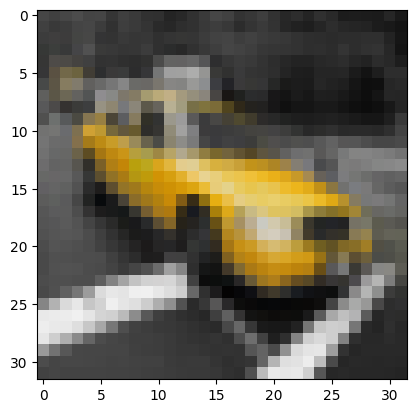

In [6]:
ind = 8
imshow(permutedims(train_x[:,:,:,indFM[ind]],[2,1,3]))
savefig("Figures/CIFAR_Original.eps", bbox_inches="tight")
savefig("Figures/CIFAR_Original.pdf", bbox_inches="tight")

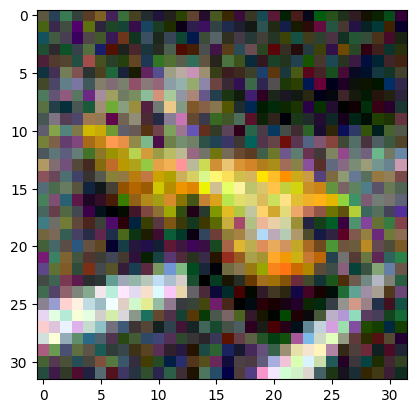

21.13823694218377


In [7]:
# Generate a corrupted version of a fundamental memory
img_x = QRPNN.imnoise(train_x[:,:,:,indFM[ind]],NoiseValue)
x = QRPNN.CIFAR2Quat(img_x)[:];
imshow(permutedims(img_x,[2,1,3]))
println(norm(x-U[:,ind]))
savefig("Figures/CIFAR_Corrupted.eps", bbox_inches="tight")
savefig("Figures/CIFAR_Corrupted.pdf", bbox_inches="tight")

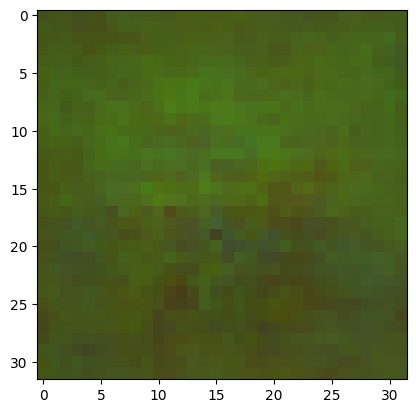

35.192535933784136


In [8]:
#
# Corelation-Based Hopfield
#
y = QRPNN.hopfield(U/(4*N), U', x, it_max);
img_y = reshape(QRPNN.Quat2CIFAR(y),32,32,3)
imshow(permutedims(img_y,[2,1,3]))
println(norm(y-U[:,ind]))
savefig("Figures/CIFAR_HopfieldCorrelation.eps", bbox_inches="tight")
savefig("Figures/CIFAR_HopfieldCorrelation.pdf", bbox_inches="tight")

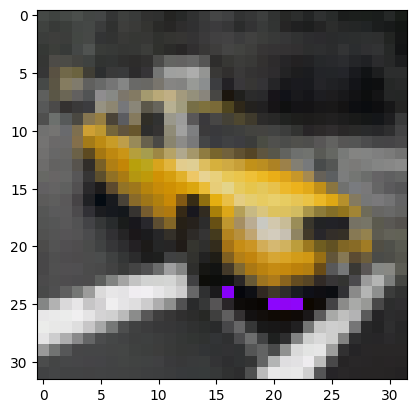

Quaternionic Hopfield Neural Network failed to converge in 1000.0 iterations.
0.3740718242892677


In [9]:
#
# Projection-Based Hopfield
#
Up = inv((U'*U)/N)*U'
y = QRPNN.hopfield(U/N, Up, x, it_max);
img_y = reshape(QRPNN.Quat2CIFAR(y),32,32,3)
imshow(permutedims(img_y,[2,1,3]))
println(norm(y-U[:,ind]))
savefig("Figures/CIFAR_HopfieldProjection.eps", bbox_inches="tight")
savefig("Figures/CIFAR_HopfieldProjection.pdf", bbox_inches="tight")

Error Identity: 4.12E+01.
Error Exponential: 3.18E-10.
Error Potential: 2.99E-15.


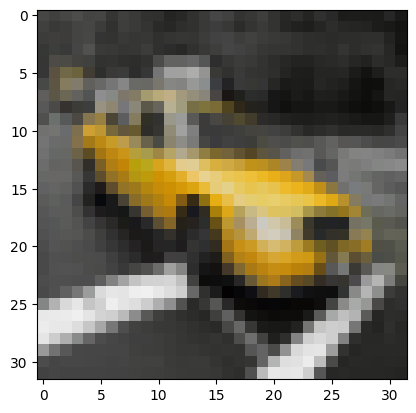

Error High_Order: 8.34E-11.


In [10]:
#
# RCNNs
#
for j=1:4
    y = QRPNN.main(fs[j],params[j], U, U, x, it_max)
    img_y = reshape(QRPNN.Quat2CIFAR(y),32,32,3)
    imshow(permutedims(img_y,[2,1,3]))
    savefig(@sprintf("Figures/CIFAR_RCNN%s.eps",fsNames[j]), bbox_inches="tight")
    savefig(@sprintf("Figures/CIFAR_RCNN%s.pdf",fsNames[j]), bbox_inches="tight")
    println(@sprintf("Error %s: %2.2E.",fsNames[j],norm(y-U[:,ind])))
end

Error Identity: 9.0E-05.
Error Exponential: 1.6E-14.
Error Potential: 3.8E-15.


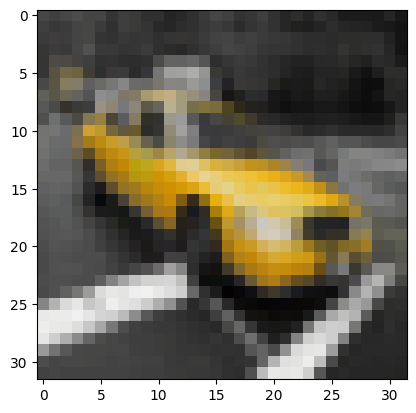

Error High_Order: 3.3E-15.


In [11]:
#
# RPNNs
#
for j=1:4
    V = QRPNN.train(fs[j],params[j],U)
    y = QRPNN.main(fs[j],params[j], U, V, x, it_max)
    img_y = reshape(QRPNN.Quat2CIFAR(y),32,32,3)
    imshow(permutedims(img_y,[2,1,3]))
    savefig(@sprintf("Figures/CIFAR_RPNN%s.eps",fsNames[j]), bbox_inches="tight")
    savefig(@sprintf("Figures/CIFAR_RPNN%s.pdf",fsNames[j]), bbox_inches="tight")
    println(@sprintf("Error %s: %2.1E.",fsNames[j],norm(y-U[:,ind])))
end